# Extract cloud mask dataset 

Requirements: 

- A GOOGLE cloud project linked to your GOOGLE account


### My project 

Google account: gelieza.gk@gmail.com


cloud project ID: sample-project-452812 


cloud project name: Sample Project


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee
import geemap
import math
import datetime
import calendar
import pytz
import pvlib


In [2]:
# Authorization and initialization of the GEE
# OBS: You must create our own project on Google
# Authenticate Earth Engine
ee.Authenticate()
#
# Initialize Earth Engine
my_project_name = 'sample-project-452812' # use here the name of your own project on Google
ee.Initialize(project=my_project_name)

In [3]:
# Convert degree to radian
def deg2rad(deg):
    return deg * math.pi / 180

# Define the center of the bounding box (Bergen, Norway)
CENTER_LAT = 60.39
CENTER_LON = 5.33

# Approximate degree adjustments for 100km x 100km box
DEG_LAT_TO_KM = 111.412  # 1 degree latitude at 60° converted to km (https://en.wikipedia.org/wiki/Latitude)
DEG_LON_TO_KM = 111.317 * math.cos(deg2rad(CENTER_LAT))  # 1 degree longitude converted to km
LAT_OFFSET = 12.5 / DEG_LAT_TO_KM  # ~10km north/south
LON_OFFSET = 12.5 / DEG_LON_TO_KM  # ~10km east/west (varies with latitude, approximation)

# Define the bounding box
BBOX = {
    "north": CENTER_LAT + LAT_OFFSET,
    "south": CENTER_LAT - LAT_OFFSET,
    "west": CENTER_LON - LON_OFFSET,
    "east": CENTER_LON + LON_OFFSET
}

print(BBOX)

# Geometry Rectangle of Form minLng, minLat, maxLng, maxLat
bergen_roi = ee.Geometry.Rectangle([BBOX["west"], BBOX["south"], BBOX["east"], BBOX["north"]])

Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10)

# Add the geometry to the map
Map.addLayer(bergen_roi, {"color": "red"}, "Bergen ROI")

# Display the weather stations
stations = {
    #"Fana - Stend": (60.261870, 5.302989),
    "Flesland Bergen": (60.292792, 5.222689),
    "Florida": (60.3833, 5.3333)
}

for name, (lat, lon) in stations.items():
    point = ee.Geometry.Point([lon, lat])
    Map.addLayer(point, {"color": "blue"}, name)
    
# Add elevation map from Copernicus DEM 30m
dem = ee.ImageCollection("COPERNICUS/DEM/GLO30").filterBounds(bergen_roi).mosaic()

elevation_vis = {
    'min': 0,
    'max': 800,
    'palette': ['blue', "green", 'brown', 'white']
}

# Clip to Bergen
dem_clipped = dem.select("DEM").clip(bergen_roi)

# Export elevation image
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=dem_clipped,
    description='Bergen_DEM_30m',
    folder='GEE_exports',   
    fileNamePrefix='bergen_dem',
    region=bergen_roi,
    scale=30,
    crs='EPSG:32632',
    maxPixels=1e13
)
#task.start()

Map.addLayer(dem_clipped, elevation_vis, 'Elevation (DEM)')

# Display the map
Map

{'north': 60.50219617276416, 'south': 60.27780382723584, 'west': 5.10273148294384, 'east': 5.55726851705616}


Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

5th percentile: 0.00 m
25th percentile: 19.87 m
50th percentile (median): 79.81 m
75th percentile: 226.36 m
95th percentile: 520.99 m


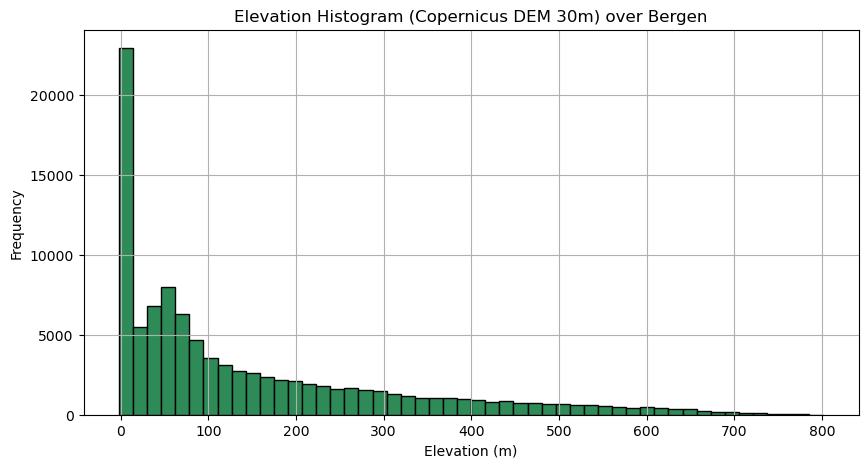

In [4]:
# Histogram of elevation
# Sample elevation pixels inside bergen_roi
def plot_elevation_statistics(dem_clipped, scale, band_name, dsm_name): 
    elevation_samples = dem_clipped.sample(
        region=bergen_roi,
        scale=scale,
        geometries=False,
        numPixels=1e5,  # Limit to avoid memory errors
        seed=42
    )

    # Get values to client
    elevation_dict = elevation_samples.reduceColumns(
        reducer=ee.Reducer.toList(),
        selectors=[band_name]
    )

    # Fetch to Python
    elevation_values = elevation_dict.get('list').getInfo()

    # Compute percentiles
    p5, p25, p50, p75, p95 = np.percentile(elevation_values, [5, 25, 50, 75, 95])

    # Print results rounded to 2 decimal places
    print(f"5th percentile: {p5:.2f} m")
    print(f"25th percentile: {p25:.2f} m")
    print(f"50th percentile (median): {p50:.2f} m")
    print(f"75th percentile: {p75:.2f} m")
    print(f"95th percentile: {p95:.2f} m")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(elevation_values, bins=50, color='seagreen', edgecolor='black')
    plt.title(f'Elevation Histogram ({dsm_name}) over Bergen')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
plot_elevation_statistics(dem_clipped, 30, 'DEM', 'Copernicus DEM 30m')

In [ ]:
# Get number of cirrus and opaque clouds # TODO: fix this 
# Load Sentinel-2 harmonized collection
s2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(bergen_roi)

# Create list of monthly time ranges
years = list(range(2015, 2025))  # Adjust as needed
months = list(range(1, 13))

def make_monthly_feature(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    
    monthly = s2.filterDate(start, end)

    def count_in_image(img):
        qa = img.select("QA60")
        cirrus = qa.bitwiseAnd(1 << 10).gt(0)
        opaque = qa.bitwiseAnd(1 << 11).gt(0)

        cirrus_count = cirrus.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=bergen_roi,
            scale=10,
            maxPixels=1e9
        ).get("QA60")

        opaque_count = opaque.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=bergen_roi,
            scale=10,
            maxPixels=1e9
        ).get("QA60")

        return ee.Feature(None, {
            "cirrus": cirrus_count,
            "opaque": opaque_count
        })

    counts = monthly.map(count_in_image)

    # Reduce all images in the month
    totals = counts.reduceColumns(
        reducer=ee.Reducer.sum().repeat(2),
        selectors=["cirrus", "opaque"]
    )

    # Safely get totals or 0 if not present
    cirrus_sum = ee.Number(ee.Algorithms.If(totals.contains("sum"), totals.get("sum"), 0))
    opaque_sum = ee.Number(ee.Algorithms.If(totals.contains("sum_1"), totals.get("sum_1"), 0))

    return ee.Feature(None, {
        "year_month": start.format('YYYY-MM'),
        "cirrus": cirrus_sum,
        "opaque": opaque_sum
    })





# Generate all year-month features
monthly_features = []
for year in years:
    for month in months:
        monthly_features.append(make_monthly_feature(year, month))

# Convert to FeatureCollection
monthly_fc = ee.FeatureCollection(monthly_features)

# Export to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=monthly_fc,
    description='Monthly_S2_Cirrus_Opaque_Counts',
    folder='GEE_exports',
    fileNamePrefix='monthly_cirrus_opaque_cloud_counts',
    fileFormat='CSV'
)
task.start()

print("Export started. Check your Google Drive > earthengine folder.")

Export started. Check your Google Drive > earthengine folder.


In [5]:
# Look at Sentinel data
s2 = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(bergen_roi)
print("Number of Sentinel Images: ", s2.size().getInfo())
s2.first()

Number of Sentinel Images:  8544


In [6]:
# Sentinel 5P
s5p = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CLOUD").filterBounds(bergen_roi)
print("Number of Sentinel-5P images:", s5p.size().getInfo())


Number of Sentinel-5P images: 35773


In [ ]:
# Function to sample each image and attach date #TODO: test this 
def sample_image(img):
    # Add image date as a band
    date_str = img.date().format("YYYY-MM-dd")
    img = img.set('date', date_str)

    # Select relevant bands
    bands = ['surface_albedo', 'cloud_optical_depth', 'cloud_base_height', 'cloud_top_height']
    sampled = img.select(bands).sample(
        region=bergen_roi,
        scale=1110,  # S5P nominal resolution
        geometries=True  # Optional: keep pixel coordinates
    ).map(lambda feat: feat.set('image_date', date_str))

    return sampled

# Test with one image 
first_image = ee.Image(s5p.first())

print("Image date:", first_image.date().format("YYYY-MM-dd").getInfo())
print("Image footprint:", first_image.geometry().bounds().getInfo())

sampled_first = sample_image(first_image)

# Export to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=sampled_first,
    description='S5P_Test_Cloud_Properties_PerPixel',
    folder='GEE_exports',
    fileNamePrefix='s5p_test_cloud_properties_per_pixel',
    fileFormat='CSV'
)
#task.start()

print("Export started for single image. Check your Google Drive > earthengine folder.")

Image date: 2018-07-05
Image footprint: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[178.17243241102318, -70.79285624086806], [181.83702598134948, -70.79285624086806], [181.83702598134948, -69.12128694066215], [178.17243241102318, -69.12128694066215], [178.17243241102318, -70.79285624086806]]]}
Export started for single image. Check your Google Drive > earthengine folder.


In [10]:

# Apply to all images and flatten to one collection
sampled_all = s5p.map(sample_image).flatten()

# Export to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=sampled_all,
    description='S5P_Cloud_Properties_PerPixel',
    folder='GEE_exports',
    fileNamePrefix='s5p_cloud_properties_per_pixel',
    fileFormat='CSV'
)
task.start()

print("Export started. Check your Google Drive > earthengine folder.")

Export started. Check your Google Drive > earthengine folder.


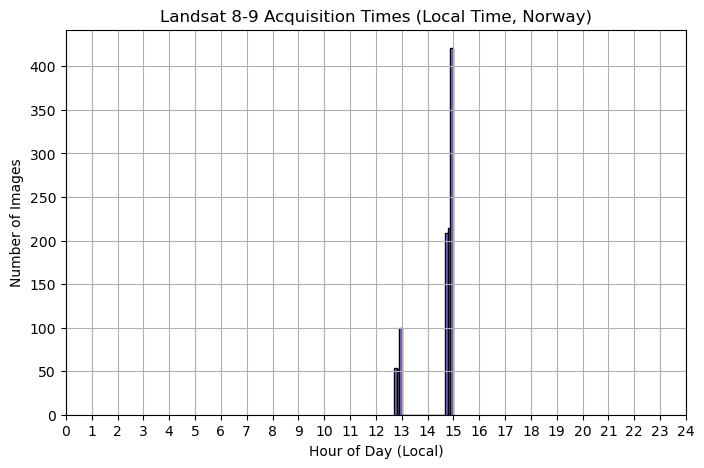

In [11]:
# Extract all timestamps
timestamps = l8_9.aggregate_array('system:time_start').getInfo()

# Convert to hour-of-day in LOCAL time (Norway, accounts for DST)
norway = pytz.timezone('Europe/Oslo')
hours_local = [norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).hour +
                norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).minute / 60.0
                for ts in timestamps]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(hours_local, bins=24, color='mediumpurple', edgecolor='black')
plt.title('Landsat 8-9 Acquisition Times (Local Time, Norway)')
plt.xlabel('Hour of Day (Local)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.xticks(range(0, 25))
plt.show()

In [8]:
l9_T1 = ee.ImageCollection("LANDSAT/LC09/C02/T1") \
    .filterBounds(bergen_roi) 
l9_T2 = ee.ImageCollection("LANDSAT/LC09/C02/T2") \
    .filterBounds(bergen_roi) 
l8_T1 = ee.ImageCollection("LANDSAT/LC08/C02/T1") \
    .filterBounds(bergen_roi) 
l8_T2 = ee.ImageCollection("LANDSAT/LC08/C02/T2") \
    .filterBounds(bergen_roi) 
l7_T1 = ee.ImageCollection("LANDSAT/LE07/C02/T1") \
    .filterBounds(bergen_roi)
l7_T2 = ee.ImageCollection("LANDSAT/LE07/C02/T2") \
    .filterBounds(bergen_roi)    
l5_T1 = ee.ImageCollection("LANDSAT/LT05/C02/T1") \
    .filterBounds(bergen_roi) 
l5_T2 = ee.ImageCollection("LANDSAT/LT05/C02/T2") \
    .filterBounds(bergen_roi) 
l4_T1 = ee.ImageCollection("LANDSAT/LT04/C02/T1") \
    .filterBounds(bergen_roi) 
l4_T2 = ee.ImageCollection("LANDSAT/LT04/C02/T2") \
    .filterBounds(bergen_roi) 
   
l4_9 = l8_T1.merge(l8_T2).merge(l9_T1).merge(l9_T2).merge(l7_T1).merge(l7_T2).merge(l5_T1).merge(l5_T2).merge(l4_T1).merge(l4_T2)
print("Number of Landsat Images: ", l4_9.size().getInfo())
l4_9.first()

Number of Landsat Images:  4043


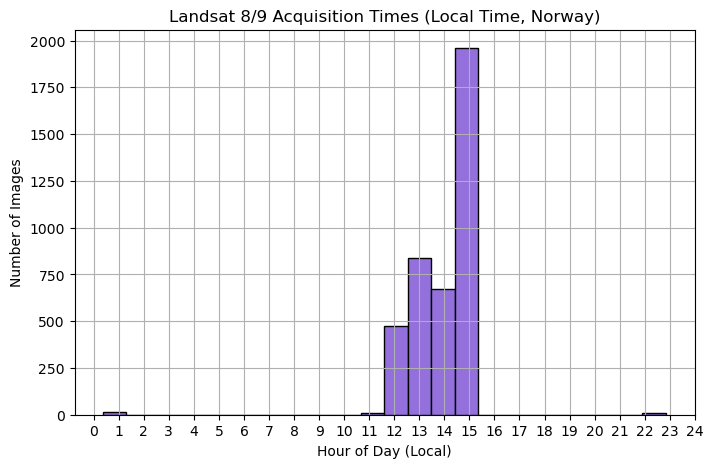

In [ ]:
# Extract all timestamps
timestamps = l4_9.aggregate_array('system:time_end').getInfo()

# Convert to hour-of-day in LOCAL time (Norway, accounts for DST)
norway = pytz.timezone('Europe/Oslo')
hours_local = [norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).hour +
                norway.fromutc(datetime.datetime.fromtimestamp(ts / 1000)).minute / 60.0
                for ts in timestamps]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(hours_local, bins=24, color='mediumpurple', edgecolor='black')
plt.title('Landsat 8/9 Acquisition Times (Local Time, Norway)')
plt.xlabel('Hour of Day (Local)')
plt.ylabel('Number of Images')
plt.grid(True)
plt.xticks(range(0, 25))
plt.show()

In [7]:
# Visualize data coverage over different periods
# Helper function to extract date parts from system time
def add_time_properties(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    month = date.get('month')
    doy = date.getRelative('day', 'year')
    season = month.expression(
        "(m <= 2 || m == 12) ? 0 : (m <= 5) ? 1 : (m <= 8) ? 2 : 3", # Winter = 0, Spring = 1, Summer = 2, Autumn = 3
        {'m': month}
    )
    return img.set({'year': year, 'month': month, 'doy': doy, 'season': season})

# Add time properties to each image
s2 = s2.map(add_time_properties)
s2.first()

In [9]:
def get_unique_dates(collection, date_format="%Y-%m-%d"):
    """Return a set of unique dates in YYYY-MM-DD format."""
    dates = collection.aggregate_array('system:time_start').getInfo()
    unique_dates = set([
        datetime.datetime.fromtimestamp(ms / 1000).strftime(date_format)
        for ms in dates
    ])
    return unique_dates

# Get unique acquisition dates
s5p_dates = get_unique_dates(s5p)
print("Unique 5P dates: ", len(s5p_dates))
s2_dates = get_unique_dates(s2_cloud)
print("Unique s2 dates: ", len(s2_dates))
s2h_dates = get_unique_dates(s2_harm)
print("Unique s2 harm dates: ", len(s2h_dates))
l8_9_dates = get_unique_dates(l8_9)
print("Unique landsat dates: ", len(l8_9_dates))

# Get overlapping measurements between Sentinel-5P and Sentinel 2
s5p_and_s2 = s5p_dates.intersection(s2_dates)
print("Number of overlapping dates (S5P & S2):", len(s5p_and_s2))

# Get s2 and s2 harm overlap
s2h_and_s2 = s2h_dates.intersection(s2_dates)
print("Number of overlapping dates (S2H & S2):", len(s2h_and_s2))

# Get s2harm and s5p overlap
s2h_and_s5p = s2h_dates.intersection(s5p_dates)
print("Number of overlapping dates (S5P & S2H):", len(s2h_and_s5p))

# Get overlapping measurements between Sentinel 5P and Landsat
s5p_and_landsat = s5p_dates.intersection(l8_9_dates)
print("Number of overlapping dates (S5P & Landsat):", len(s5p_and_landsat))


Unique 5P dates:  2563
Unique s2 dates:  1929
Unique s2 harm dates:  954
Unique landsat dates:  531
Number of overlapping dates (S5P & S2): 1928
Number of overlapping dates (S2H & S2): 954
Number of overlapping dates (S5P & S2H): 954
Number of overlapping dates (S5P & Landsat): 531


In [7]:

# Get histograms 
hist_year = s2.aggregate_histogram("year").getInfo()
hist_month = s2.aggregate_histogram("month").getInfo()
hist_season = s2.aggregate_histogram("season").getInfo()
hist_doy = s2.aggregate_histogram("doy").getInfo()

# Convert keys to numeric
hist_month = {int(k) : v for k, v in hist_month.items()}
hist_doy = {int(k): v for k, v in hist_doy.items()}


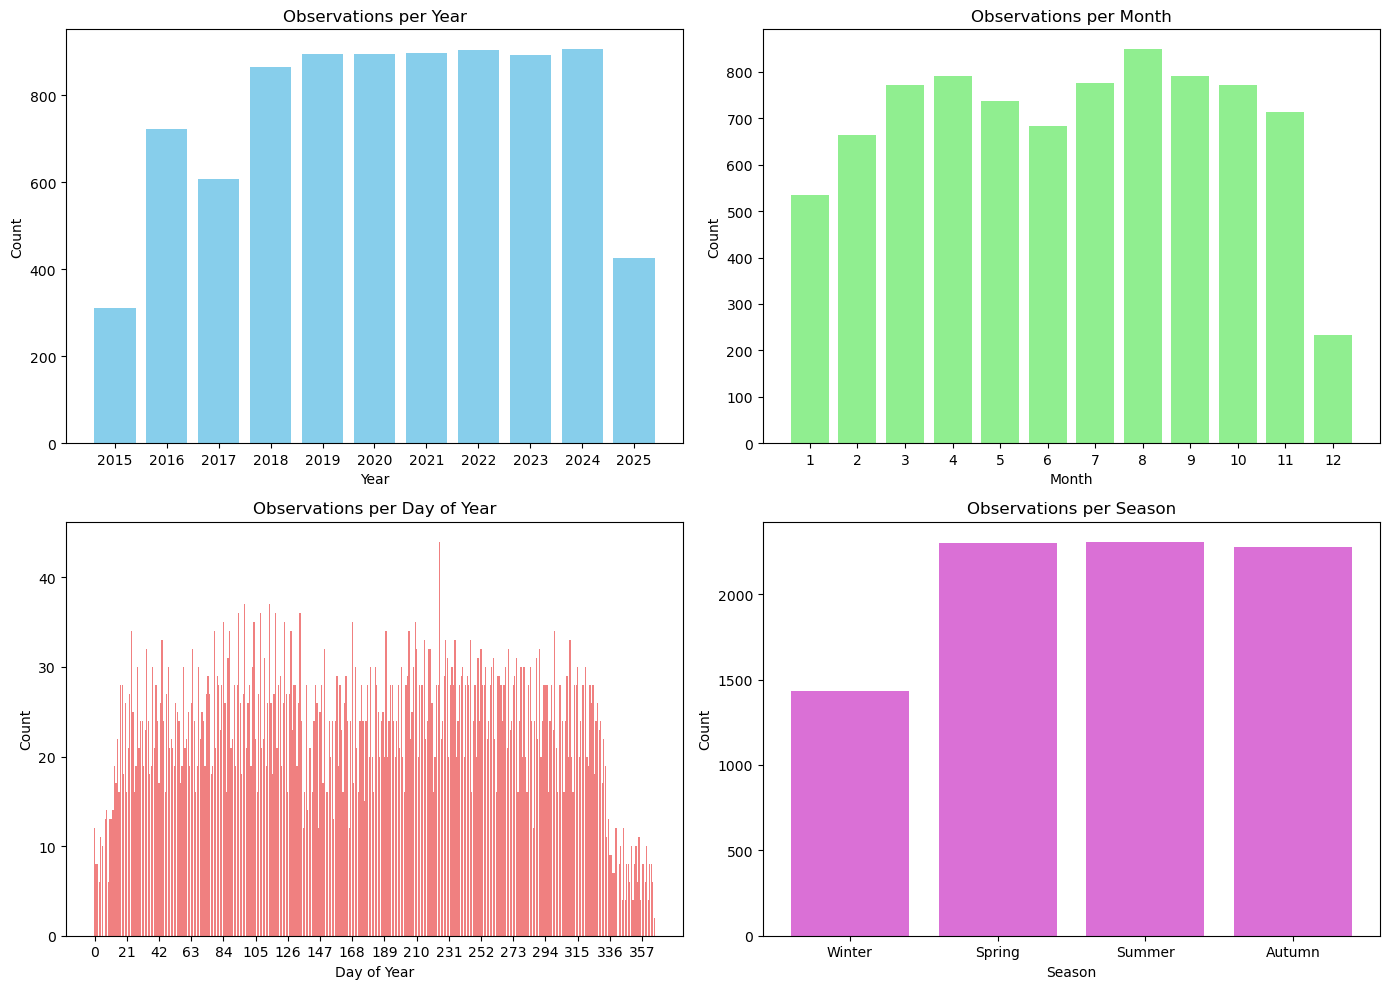

In [8]:

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].bar(hist_year.keys(), hist_year.values(), color='skyblue')
axs[0, 0].set_title('Observations per Year')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Count')

axs[0, 1].bar(hist_month.keys(), hist_month.values(), color='lightgreen')
axs[0, 1].set_title('Observations per Month')
axs[0, 1].set_xlabel('Month')
axs[0,1].set_xticks(range(1,13))
axs[0, 1].set_ylabel('Count')

axs[1, 0].bar(hist_doy.keys(), hist_doy.values(), color='lightcoral')
axs[1, 0].set_title('Observations per Day of Year')
axs[1, 0].set_xlabel('Day of Year')
axs[1, 0].set_ylabel('Count')
axs[1, 0].set_xticks([k for k in hist_doy.keys() if k % 21 == 0])


axs[1, 1].bar(hist_season.keys(), hist_season.values(), color='orchid')
axs[1, 1].set_title('Observations per Season')
axs[1, 1].set_xlabel('Season')
axs[1, 1].set_ylabel('Count')
axs[1,1].set_xticklabels(["Winter", "Spring", "Summer", "Autumn"])

plt.tight_layout()
plt.show()

In [7]:
# Nested dict for year-month
years = range(2015, 2026)
months = range(1,13)
hist_year_month = {year : {m : 0 for m in months} for year in years}

for year in years: 
    s2_year = s2.filter(ee.Filter.eq('year', year))
    year_month_counts = s2_year.aggregate_histogram("month").getInfo()
    for month, count in year_month_counts.items(): 
        hist_year_month[year][int(month)] = count
    print("hist year ", year, ": ", hist_year_month[year])

hist year  2015 :  {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 43, 8: 134, 9: 73, 10: 20, 11: 38, 12: 3}
hist year  2016 :  {1: 22, 2: 38, 3: 50, 4: 74, 5: 64, 6: 72, 7: 82, 8: 78, 9: 80, 10: 92, 11: 70, 12: 0}
hist year  2017 :  {1: 17, 2: 39, 3: 39, 4: 39, 5: 39, 6: 48, 7: 83, 8: 73, 9: 75, 10: 82, 11: 72, 12: 2}
hist year  2018 :  {1: 50, 2: 70, 3: 85, 4: 83, 5: 82, 6: 85, 7: 87, 8: 80, 9: 81, 10: 82, 11: 76, 12: 3}
hist year  2019 :  {1: 48, 2: 75, 3: 81, 4: 82, 5: 75, 6: 84, 7: 83, 8: 80, 9: 82, 10: 87, 11: 78, 12: 39}
hist year  2020 :  {1: 64, 2: 78, 3: 80, 4: 84, 5: 84, 6: 83, 7: 80, 8: 82, 9: 81, 10: 76, 11: 73, 12: 29}
hist year  2021 :  {1: 67, 2: 72, 3: 83, 4: 78, 5: 82, 6: 77, 7: 78, 8: 82, 9: 78, 10: 82, 11: 79, 12: 39}
hist year  2022 :  {1: 70, 2: 73, 3: 80, 4: 79, 5: 82, 6: 78, 7: 78, 8: 82, 9: 77, 10: 84, 11: 77, 12: 43}
hist year  2023 :  {1: 66, 2: 73, 3: 86, 4: 74, 5: 82, 6: 78, 7: 79, 8: 75, 9: 84, 10: 83, 11: 74, 12: 39}
hist year  2024 :  {1: 68, 2: 74, 3: 82, 4: 74

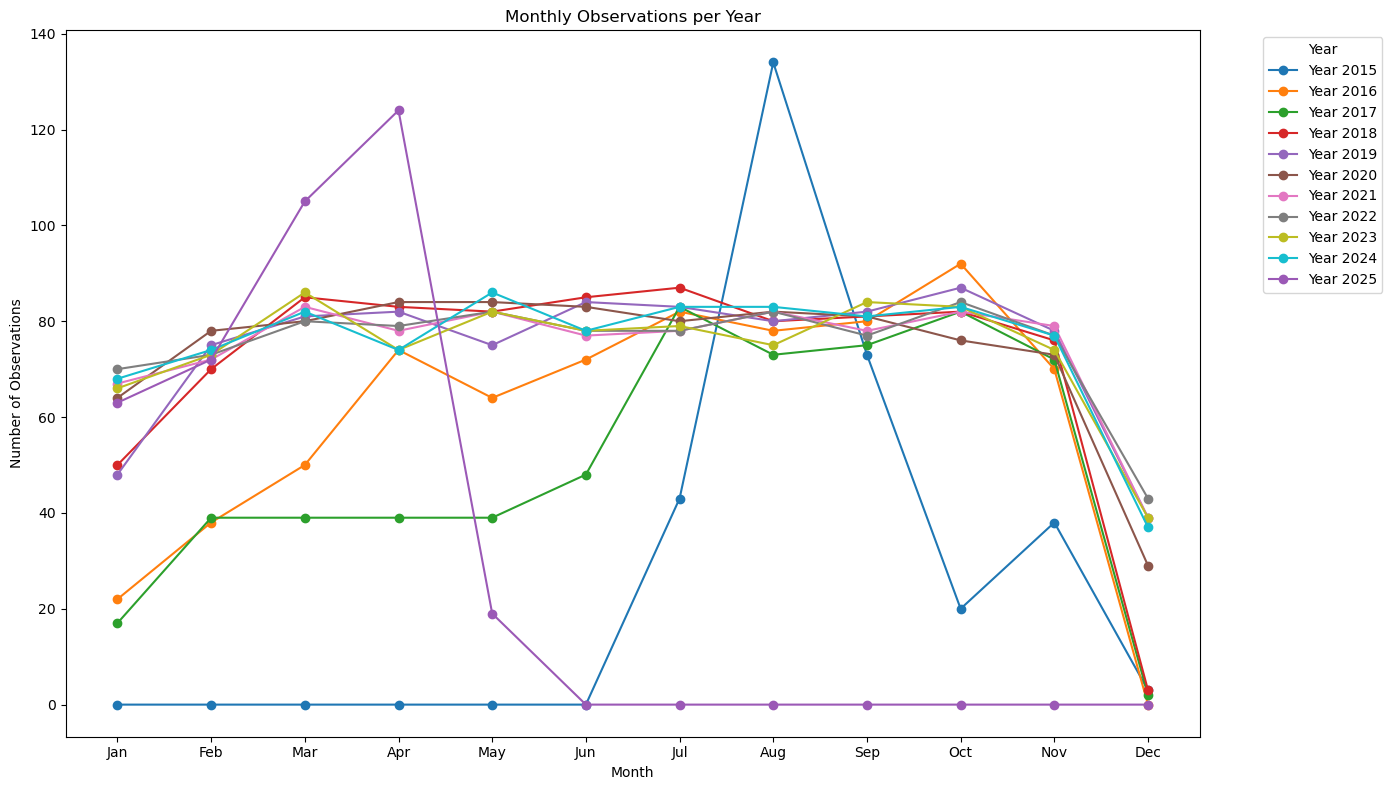

In [10]:
# Plot the observations per month for each year
fig, ax = plt.subplots(figsize=(14, 8))
months = range(1,13)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9b59b6', '#f39c12']

for idx, year in enumerate(years):
    ax.plot(months, hist_year_month[year].values(), label=f'Year {year}', color=colors[idx], marker='o')

ax.set_title('Monthly Observations per Year')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Observations')
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
# Any invalid data? data should be within 0 to 100 

# Binary mask for cloud with 
CLD_PRB_THRESH = 50 # turn int data to binary using different thresholds

def add_cloud_mask(image):
    cloud_mask = image.select('probability').gt(CLD_PRB_THRESH).rename('cloud_mask')
    return image.addBands(cloud_mask)

def add_constant(image): 
    valid_pixel = image.select('probability').gt(0).rename('valid_pixel')
    return image.addBands(valid_pixel)

#s2 = s2.map(add_cloud_mask)
#s2 = s2.map(add_constant)
#s2.first()

In [8]:
# Test this with single image for which cloud cover is known because it takes too much time over whole collection
image = ee.Image('COPERNICUS/S2_CLOUD_PROBABILITY/20150729T110026_20150729T110029_T32VKM')
image = add_cloud_mask(image)
image = add_constant(image)

cloud_mask = image.select('cloud_mask').eq(1)

print(image.bandNames().getInfo())     # Should only be ['constant']
print(cloud_mask.bandNames().getInfo())   # Should only be ['cloud_mask']

# 5. Use weighted sum to count valid pixels in the region
total_pixels = image.select('valid_pixel').reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=bergen_roi,
    scale=10,
    maxPixels=1e9
).get('valid_pixel')

# Count cloudy pixels (value = 1)
cloudy_pixels = cloud_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=bergen_roi,
    scale=10,
    maxPixels=1e9
).get('cloud_mask')  # server-side ee.Number

# 6. Print the result
print('Total valid pixels (weighted):', total_pixels.getInfo())
print('Cloudy pixels (weighted): ', cloudy_pixels.getInfo())
print('coverage : ', cloudy_pixels.getInfo()/total_pixels.getInfo())

image_clipped = image.clip(bergen_roi)
visParams_cloud_mask = {'bands' : ['cloud_mask'], 'min' : 0, 'max':1, 'opacity': 0.8, 'palette': ['0000FF', '00FFFF']}
visParams_cloud_prob = {'bands' : ['probability'], 'min' : 0, 'max':100, 'opacity': 0.8, 'palette': ['000080', 'FF0000']}

Map.addLayer(image_clipped, visParams_cloud_mask, 'Cloud Mask 29th July 2015')
Map.addLayer(image_clipped, visParams_cloud_prob, 'Cloud Prob 29th July 2015')
Map

['probability', 'cloud_mask', 'valid_pixel']
['cloud_mask']
Total valid pixels (weighted): 2946446.635294118
Cloudy pixels (weighted):  1705697.4313725492
coverage :  0.5788998215480269


Map(bottom=75855.0, center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widg…

In [9]:
def add_cloud_cover(img):
    # Assume cloud_mask is a binary mask: 1 = cloud, 0 = clear
    cloud_mask = img.select('cloud_mask').eq(1)

    # Count total pixels 
    total_pixels = img.select('valid_pixel').reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e9
    ).get('valid_pixel')

    # Count cloudy pixels (value = 1)
    cloudy_pixels = cloud_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e9
    ).get('cloud_mask')  
    
    avg_prob = img.select('probability').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e9
    ).get('probability')

    # Calculate cloud cover % - Avoid division by zero
    cloud_cover = ee.Number(cloudy_pixels).divide(ee.Number(total_pixels)).multiply(100)
        
    # Attach as image property
    return img.set({'cloud_cover': cloud_cover.round(), # round to nearest integer
                    'cloudy_pixels': cloudy_pixels,
                    'total_pixels': total_pixels,
                    'avg_cloud_prob': avg_prob}) 


s2 = s2.map(add_cloud_cover)
s2.first()

In [ ]:
# Convert to feature for export 

def img_to_feature(img): 
    return ee.Feature(None, {'cloud_cover': img.get('cloud_cover'), 
                             'cloudy_pixels': img.get('cloudy_pixels'),
                             'total_pixels': img.get('total_pixels'),
                             'avg_cloud_prob': img.get('avg_cloud_prob'),
                             'doy': img.get('doy'),
                             'year': img.get('year'), 
                             'month': img.get('month'),
                             'season': img.get('season'),
                             'system:index': img.get('system:index'),
                             'system:time_start' : img.get('system:time_start'),
                             'system:time_end': img.get('system:time_end')})
    
cloud_cover_f_collection = s2.map(img_to_feature)

# Export task to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=cloud_cover_f_collection,
    description='s2_cloud_cover',
    fileFormat='CSV'
)

# Start the export task
#task.start()

In [10]:
# High resolution cloud frequency map 
# Define thresholds
mixed_sky_threshold = 5
overcast_sky_threshold = 90

# Filter Sentinel-2 images by cloud cover metadata
mixed_skytype = s2.filter(
    ee.Filter.rangeContains('cloud_cover', mixed_sky_threshold, overcast_sky_threshold)
)

# Compute mean cloud probability
cloud_mask_mean = mixed_skytype.select('cloud_mask').mean().clip(bergen_roi)

# Export
def export_img(img, description):
    task = ee.batch.Export.image.toDrive(
        image=img,
        description=description,
        folder='GEE_exports',
        region=bergen_roi,
        scale=10,
        crs='EPSG:32632',          # Projected CRS in meters
        maxPixels=1e13
    )
    task.start()
    

#export_img(cloud_mask_mean, f"Cloud_mask_mean_alltime_mixed")
#export_img(cloud_prob_percentiles.select(['probability_p50']), f"Cloud_prob_median_alltime")
#export_img(cloud_prob_percentiles.select(['probability_p75']), f"Cloud_prob_Q3_alltime")

In [11]:
# Aggregate for each month/season and plot the same image 
def monthly_cloud_freq(month):
    filtered = mixed_skytype.filter(ee.Filter.calendarRange(month, month, 'month'))
    return filtered.select('cloud_mask').mean().set('month', month)

# Define a function that computes 25th, 50th, and 75th percentiles for each month
def monthly_cloud_quartiles(month):
    filtered = mixed_skytype.filter(ee.Filter.calendarRange(month, month, 'month'))
    percentiles = filtered.select('probability').reduce(
        ee.Reducer.percentile([25, 50, 75])
    )
    return percentiles.set('month', month)


months = ee.List.sequence(1, 12)
monthly_images = months.map(lambda m: monthly_cloud_freq(ee.Number(m)))

monthly_collection = ee.ImageCollection.fromImages(monthly_images)

# Export images
for m in range(1, 13):
    img = ee.Image(monthly_collection.filter(ee.Filter.eq('month', m)).first())
    export_img(img, f"Cloud_mask_mean_month{m}_mixed")
    #export_img(img.select(['probability_p25']), f"Cloud_prob_Q1_month{m}")
    #export_img(img.select(['probability_p50']), f"Cloud_prob_median_month{m}")
    #export_img(img.select(['probability_p75']), f"Cloud_prob_Q3_month{m}")

In [12]:
# Aggregate for each season and export the image
def seasonal_cloud_freq(season):
    filtered = mixed_skytype.filter(ee.Filter.eq('season', season))
    return filtered.select('cloud_mask').mean().set('season', season)

def seasonal_cloud_quartiles(season):
    filtered = mixed_skytype.filter(ee.Filter.eq('season', season))
    percentiles = filtered.select('probability').reduce(
        ee.Reducer.percentile([25, 50, 75])
    )
    return percentiles.set('season', season)


# List of seasons: 0 = winter, 1 = spring, 2 = summer, 3 = autumn
seasons = ee.List.sequence(0, 3)
seasonal_images = seasons.map(lambda s: seasonal_cloud_freq(ee.Number(s)))

# Convert list of images to an ImageCollection
seasonal_collection = ee.ImageCollection.fromImages(seasonal_images)

season_names = ['Winter', 'Spring', 'Summer', 'Autumn']
for s in range(4):
    img = ee.Image(seasonal_collection.filter(ee.Filter.eq('season', s)).first())
    export_img(img, f"Cloud_mask_mean_{season_names[s]}_mixed")
    #export_img(img.select(['probability_p25']), f"Cloud_prob_Q1_{season_names[s]}")
    #export_img(img.select(['probability_p50']), f"Cloud_prob_median_{season_names[s]}")
    #export_img(img.select(['probability_p75']), f"Cloud_prob_Q3_{season_names[s]}")

In [11]:
# Aggregate for each year and export the image
def yearly_cloud_freq(year):
    filtered = s2.filter(ee.Filter.eq('year', year))
    return filtered.select('cloud_mask').mean().set('year', year)

# List of years 2015-2025
years = ee.List.sequence(2015, 2025)
yearly_images = years.map(lambda y: yearly_cloud_freq(ee.Number(y)))

# Convert list of images to an ImageCollection
yearly_collection = ee.ImageCollection.fromImages(yearly_images)

for y in range(2015,2026):
    img = ee.Image(yearly_collection.filter(ee.Filter.eq('year', y)).first())
    export_img(img, f"Cloud_mask_mean_{y}")

In [2]:
# Create single multiband image for clustering analysis
img_mean_seasons = ee.Image('projects/sample-project-452812/assets/Cloud_mask_mean_seasons')
img_mean_months = ee.Image('projects/sample-project-452812/assets/Cloud_mask_mean_months')
img_Q1 = ee.Image('projects/sample-project-452812/assets/Cloud_prob_Q1_months_seasons')
img_median = ee.Image('projects/sample-project-452812/assets/Cloud_prob_median_months_seasons')
img_mean_alltime = ee.Image('projects/sample-project-452812/assets/Cloud_mask_mean_alltime_EPSG32632')

# Rename Bands 
img_mean_seasons = img_mean_seasons.rename([
    'mean_winter', 'mean_spring', 'mean_summer', 'mean_autumn'
]).multiply(100)

img_mean_months = img_mean_months.rename([
    'mean_jan', 'mean_feb', 'mean_mar', 'mean_apr',
    'mean_may', 'mean_jun', 'mean_jul', 'mean_aug',
    'mean_sep', 'mean_oct', 'mean_nov', 'mean_dec'
]).multiply(100)

img_Q1 = img_Q1.rename(["q1_alltime",
                        "q1_jan", "q1_feb", "q1_mar", "q1_apr","q1_may",
                        "q1_jun","q1_jul","q1_aug","q1_sep","q1_oct",
                        "q1_nov","q1_dec",
                        "q1_winter", "q1_spring", "q1_summer", "q1_autumn"])

img_median = img_median.rename(["median_alltime",
                        "median_jan", "median_feb", "median_mar", "median_apr","median_may",
                        "median_jun","median_jul","median_aug","median_sep","median_oct",
                        "median_nov","median_dec",
                        "median_winter", "median_spring", "median_summer", "median_autumn"])

img_mean_alltime = img_mean_alltime.rename(["mean_alltime"])

combined = img_mean_seasons.addBands(img_mean_months).addBands(img_Q1).addBands(img_median).addBands(img_mean_alltime)
combined

NameError: name 'ee' is not defined

In [ ]:
""" # Export combined multi-band image
description = f'features_multiband_image_rescaled'
# Export image 
export_task = ee.batch.Export.image.toDrive(
    image=combined,
    description=description,
    folder='GEE_exports',  
    fileNamePrefix=description,
    region=bergen_roi,     
    scale=10,           
    maxPixels=1e13         # Increase if needed
)

# Start the export task
export_task.start() """

In [7]:
# Stratified sampling to cover all areas with equal parts
# Parameters
num_tiles_x = 5
num_tiles_y = 5
samples_per_tile = 4000  # total = 25 * 4000 = 100000
num_pixels = num_tiles_x * num_tiles_y * samples_per_tile
scale = 10

# Get bounding box of the ROI
bounds = bergen_roi.bounds().coordinates().get(0)
coords = ee.List(bounds)

# Extract min/max coordinates
xmin = ee.Number(ee.List(coords.get(0)).get(0))
ymin = ee.Number(ee.List(coords.get(0)).get(1))
xmax = ee.Number(ee.List(coords.get(2)).get(0))
ymax = ee.Number(ee.List(coords.get(2)).get(1))

# Tile width/height
dx = xmax.subtract(xmin).divide(num_tiles_x)
dy = ymax.subtract(ymin).divide(num_tiles_y)

# Function to create one tile
def create_tile(i, j):
    x0 = xmin.add(dx.multiply(i))
    y0 = ymin.add(dy.multiply(j))
    x1 = x0.add(dx)
    y1 = y0.add(dy)
    tile = ee.Geometry.Rectangle([x0, y0, x1, y1])
    return tile

# Generate all tiles
tiles = []
for i in range(num_tiles_x):
    for j in range(num_tiles_y):
        tile = create_tile(i, j)
        tiles.append(tile)

# Sample from each tile
samples = [combined.sample(
    region=tile,
    scale=scale,
    numPixels=samples_per_tile,
    seed = 0, # default seed = 0
    geometries=False
) for tile in tiles]

# Merge all tile samples
sample_collection = ee.FeatureCollection(samples).flatten()

In [ ]:
# K-means clustering to identify cloudiness neighborhoods 
# good results with:    numPixels 40000, seed=42, wekaKMeans init = 2, seed = 42, n=4
#                       numPixels 50000, seed=42, wekaKMeans init=0, seed = 4, n=4
#       stratified Sample, seed 42, numPixels 50000, init=0, seed = 4
#       stratified Sample, seed 42, numPixels 50000, init=1, seed = 3
#       stratified Sample, seed 42, numPixels 50000, init=1, seed = 42
#       stratified Sample, seed 10, numPixels 50000, init=1, seed = 42
#       stratified Sample, seed 10, numPixels 50000, init=1, seed = 10
#       stratified Sample, seed 10, numPixels 50000, init=1, seed = default (0)
#       stratified Sample, seed default (0), numPixels 50000, init=1, seed = default (0) 45 sec
#       stratified Sample, seed default (0), numPixels 62500, init=1, seed = default (0) 2 min 22
#       stratified Sample, seed default (0), numPixels 75000, init=1, seed = default (0) 1 min 41
#       stratified Sample, seed default (0), numPixels 100000, init=1, seed = default (0) 2 min 56 s

kmeans_seed = 0 # default seed
kmeans_init = 1 # k-means

n_clusters = 2  # You can experiment with 4–10
clusterer = ee.Clusterer.wekaKMeans(nClusters=n_clusters, 
                                    init = kmeans_init,
                                    seed = kmeans_seed, 
                                    maxIterations=100).train(
                                        features=sample_collection,
                                        inputProperties=combined.bandNames()
                                    )
                                    
result = combined.cluster(clusterer)

description = f'kmeans_clusters_k{n_clusters}_trainsize{num_pixels}'
# Export image 
export_task = ee.batch.Export.image.toDrive(
    image=result,
    description=description,
    folder='GEE_exports',  
    fileNamePrefix=description,
    region=bergen_roi,     
    scale=scale,           
    maxPixels=1e13         # Increase if needed
)

# Start the export task
#export_task.start()

In [1]:

cluster_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',  '#991122']  # red, green, yellow, blue, orange
viz_params = {
    'min': 0,
    'max': n_clusters - 1,
    'palette': cluster_colors[:n_clusters]
}


Map = geemap.Map()
Map.centerObject(bergen_roi, 10)
Map.addLayer(result, viz_params, f"KMeans Clusters (k={n_clusters})")
Map

NameError: name 'n_clusters' is not defined

In [ ]:
# Add the cluster band to each band separately
clustered = combined.addBands(result.rename("cluster"))

band_names = combined.bandNames().getInfo()
cluster_profiles = []

for band in band_names:
    img = clustered.select([band, 'cluster'])
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.stdDev(), '', True)
            .combine(ee.Reducer.minMax(), '', True)
            .combine(ee.Reducer.median(), '', True)
            .combine(ee.Reducer.count(), '', True).group(
            groupField=1,
            groupName='cluster'
        ),
        geometry=bergen_roi,
        scale=10,
        maxPixels=1e13
    )
    
    groups = stats.get('groups').getInfo()
    
    for group in groups:
        cluster_profiles.append({
            'cluster': group['cluster'],
            'band': band,
            'mean': group['mean'],
            'stdDev': group.get('stdDev'),
            'min': group.get('min'),
            'max': group.get('max'),
            'median': group.get('median'),
            'count': group.get('count')
        })

# Convert to DataFrame
df = pd.DataFrame(cluster_profiles)
# multiply mean values * 100 because they are stored with values 0 to 1
df.loc[df['band'].str.contains('mean', case=False, na=False), 'mean'] *= 100


# Add percentage of clusters of all pixels
total_count = df.groupby('cluster')['count'].mean().sum()  # average over bands to avoid duplicates
df['proportion'] = df['count'] / total_count

# Pivot to get band values per cluster
df.to_csv(f'../../data/processed/cluster_statistics_k{n_clusters}_trainsize{num_pixels}.csv', index=False)

In [54]:
df.loc[df['band'].str.contains('mean', case=False, na=False), 'mean'] *= 100
df[df["band"] == "mean_alltime"].head()

,cluster,band,mean,stdDev,min,max,median,count,proportion
150,0,mean_alltime,70.247306,0.014087,0.652979,0.808717,0.701675,2707020,0.431571
151,1,mean_alltime,71.506666,0.018145,0.654281,0.974556,0.713830,1791412,0.285599
152,2,mean_alltime,66.812741,0.012026,0.627625,0.712787,0.669193,1774051,0.282831


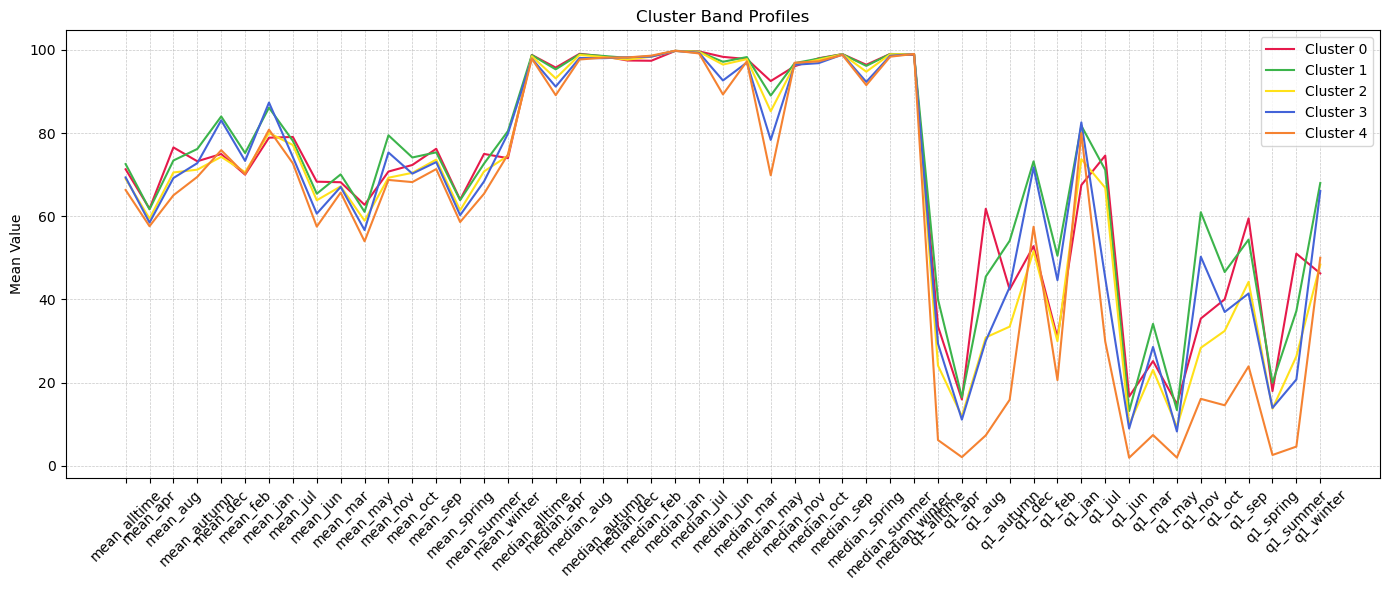

In [ ]:
df = pd.read_csv("../../data/processed/cluster_statistics_k5_trainsize100000.csv")
#df.loc[df['band'].str.contains('mean', case=False, na=False), 'mean'] *= 100

pivot_df = df.pivot(index='cluster', columns='band', values='mean').reset_index()

plt.figure(figsize=(14, 6))  # Wider and a bit taller

for i, row in pivot_df.iterrows():
    plt.plot(pivot_df.columns[1:], row[1:], label=f'Cluster {int(row["cluster"])}', color=cluster_colors[i])

plt.legend()
plt.title("Cluster Band Profiles")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add gridlines
plt.tight_layout()
plt.savefig(f"../../output/cluster_band_profiles_k{n_clusters}.png")
plt.show()

In [78]:
from scipy.spatial.distance import pdist
import numpy as np
# Analyze discriminability

centroids = pivot_df.drop(columns=['cluster']).values
inter_cluster_distance = pdist(centroids).mean()  # Euclidean distance
print(f"Avg. inter-cluster distance: {inter_cluster_distance:.2f}")

# Intra-cluster variance
intra_variance = df.groupby('cluster')['stdDev'].mean().sum()
print(f"Total intra-cluster stdDev: {intra_variance:.2f}")

Avg. inter-cluster distance: 73.58
Total intra-cluster stdDev: 19.33


In [13]:
# Aerosol data from 
maiac = ee.ImageCollection("MODIS/061/MCD19A2_GRANULES").filterDate("2016-01-01", "2024-12-31").filterBounds(bergen_roi)

# Define function to extract monthly means
def monthly_mean(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    
    monthly_coll = maiac.filterDate(start, end)
    
    monthly_mean_img = monthly_coll.select([
        "Optical_Depth_055", "AngstromExp_470-780"
    ]).mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=bergen_roi,
        scale=1000,  # MAIAC resolution ~1 km
        maxPixels=1e9
    ).set('year', year) \
    .set('month', month) \
    .set('date', start.format('YYYY-MM'))
    
    return ee.Feature(None, monthly_mean_img)

# Create list of months from 2016 to 2024
def generate_monthly_list(start_year, end_year):
    dates = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            dates.append((year, month))
    return dates

# Map over months and extract values
monthly_dates = generate_monthly_list(2016, 2024)
features = ee.FeatureCollection([monthly_mean(year, month) for year, month in monthly_dates])

# Export to CSV using geemap
out_csv = 'maiac_monthly_bergen.csv'
geemap.ee_export_vector(features, filename=out_csv)
print(f"Exported monthly mean AOD and Angstrom exponent to {out_csv}")

Generating URL ...
Please wait ...
Data downloaded to /mnt/c/Users/gelie/Home/ComputationalScience/MA/master_thesis/src/maiac_monthly_bergen.csv
Exported monthly mean AOD and Angstrom exponent to maiac_monthly_bergen.csv


In [6]:
# Combine Sentinel-2 cloud probability, Sentinel-2 harmonized, and Sentinel-5P in one collection 

def print_collection_info(collection, name=""):
    """Prints the number of images and unique acquisition dates in a collection."""
    total_size = collection.size().getInfo()
    unique_dates = collection.aggregate_array('system:time_start') \
        .map(lambda t: ee.Date(t).format('YYYY-MM-dd')) \
        .distinct().size().getInfo()
    
    print(f"📦 {name} - Total images: {total_size}, Unique acquisition dates: {unique_dates}")
    return total_size, unique_dates

# Sentinel-5P cloud properties
s5p = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CLOUD").filterBounds(bergen_roi) \
    .select(["cloud_optical_depth", "surface_albedo", "cloud_base_height"])

""" # Sort and get first and last dates
s5p_sorted = s5p.sort('system:time_start')
start_date = ee.Date(s5p_sorted.first().get('system:time_start'))
end_date = ee.Date(s5p_sorted.sort('system:time_start', False).first().get('system:time_start'))
# Get milliseconds from Earth Engine Date objects
start_millis = start_date.getInfo()['value']
end_millis = end_date.getInfo()['value']
# Convert to datetime
start_datetime = datetime.datetime.fromtimestamp(start_millis / 1000)
end_datetime = datetime.datetime.fromtimestamp(end_millis / 1000)
# Print in readable format
print("Start date:", start_datetime) # 2018-07-06
print("End date:", end_datetime) # 2025-07-13
 """
startDate = "2018-07-06"
endDate = "2025-07-13"

# Sentinel-2 cloud probability 
s2_cloud = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY") \
    .filterDate(startDate, endDate).filterBounds(bergen_roi).map(add_cloud_mask)
    
#display(s2_cloud.first())

# Sentinel-2 Harmonized top of atmosphere
def extract_s2harm_cloud_bits(image):
    qa60 = image.select("QA60")
    
    # Extract Bit 10 (opaque clouds)
    opaque = qa60.bitwiseAnd(1 << 10).rightShift(10).rename("is_opaque")

    # Extract Bit 11 (cirrus clouds)
    cirrus = qa60.bitwiseAnd(1 << 11).rightShift(11).rename("is_cirrus")

    return image.addBands([opaque, cirrus]).select(["is_opaque", "is_cirrus"])

# Filter and process Sentinel-2 Harmonized
s2_harm = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .map(extract_s2harm_cloud_bits)

#display(s2_harm.first())

def extract_landsat_cloud_bits(image):
    """
    Extracts cloud_mask and is_cirrus bands from the QA_PIXEL band in Landsat Collection.
    - cloud_mask = 1 if Bit 3 is set (cloud) AND Bit 6 is NOT set (not clear)
    - is_cirrus = Bit 2
    The original QA_PIXEL band is removed.
    """
    qa = image.select("QA_PIXEL")

    # Extract bits
    bit2 = qa.bitwiseAnd(1 << 2).rightShift(2)  # Cirrus
    bit3 = qa.bitwiseAnd(1 << 3).rightShift(3)  # Cloud
    bit6 = qa.bitwiseAnd(1 << 6).rightShift(6)  # Clear

    # cloud_mask = 1 if cloud (bit3==1) AND NOT clear (bit6==0)
    cloud_mask = bit3.And(bit6.Not())

    # Rename and add bands
    return image \
        .addBands(cloud_mask.rename("cloud_mask")) \
        .addBands(bit2.rename("is_cirrus")) \
        .select(["cloud_mask", "is_cirrus"])  # drop QA_PIXEL


# Landsat
l9_T1 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .map(extract_landsat_cloud_bits)
l9_T2 = ee.ImageCollection("LANDSAT/LC09/C02/T2_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .map(extract_landsat_cloud_bits)
l8_T1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .map(extract_landsat_cloud_bits)
l8_T2 = ee.ImageCollection("LANDSAT/LC08/C02/T2_L2") \
    .filterDate(startDate, endDate) \
    .filterBounds(bergen_roi) \
    .map(extract_landsat_cloud_bits)
   
l8_9 = l8_T1.merge(l8_T2).merge(l9_T1).merge(l9_T2)

#display(l8_9.first())

#print_collection_info(s5p, "Sentinel-5P")
#print_collection_info(s2_cloud, "Sentinel-2 Cloud Probability")
#print_collection_info(s2_harm, "Sentinel-2 Harmonized")
#print_collection_info(l8_9, "Landsat 8/9 L2 Combined")

In [7]:

# Pair S5P with S2 cloud, s2 harm or landsat images 

def print_unique_dates_per_month(image_collection, name=""):
    """
    Prints the number of unique acquisition dates per calendar month for a given Earth Engine ImageCollection.
    
    Args:
        image_collection (ee.ImageCollection): The input image collection.
        name (str): Optional label for the dataset being analyzed.
    """
    # Get all acquisition timestamps
    timestamps = image_collection.aggregate_array('system:time_start')

    # Convert to YYYY-MM-DD strings
    unique_dates = timestamps.map(lambda t: ee.Date(t).format('YYYY-MM-dd')).distinct()

    # Extract month from each unique date
    months = unique_dates.map(lambda d: ee.Number.parse(ee.String(d).slice(5, 7)))  # slice gets MM from YYYY-MM-DD

    # Count occurrences per month
    month_counts = months.reduce(ee.Reducer.frequencyHistogram()).getInfo()

    # Convert and print
    month_distribution = {calendar.month_name[int(k)]: v
                          for k, v in sorted(month_counts.items(), key=lambda x: int(x[0]))}

    print(f"\n📅 Unique acquisition dates per month for {name}:")
    for month, count in month_distribution.items():
        print(f"{month}: {count}")
      
# Merge all bands from join result 
def merge_all_bands(join_result):
    primary = ee.Image(join_result.get('primary'))  # S2 cloud + harmonized (already cat-ed)
    secondary = ee.Image(join_result.get('secondary'))  # S5P
    return primary.addBands(secondary)

# For each s2 cloud property image, join with s2 harmonized +- 1 min 
# (they should have the same acquisition timestamps)
min10_millis = 10 * 60 * 1000  # 10 min
max1minDiffFilter = ee.Filter.maxDifference(**{
    'difference': min10_millis,
    'leftField': 'system:time_start',
    'rightField': 'system:time_start'
})

spatialFilter = ee.Filter.intersects(**{
  'leftField': '.geo',
  'rightField': '.geo'})

combined_filter = ee.Filter.And(spatialFilter, max1minDiffFilter)

inner_join = ee.Join.inner()

inner_joined_s2_s2h = inner_join.apply(s2_cloud, s2_harm, combined_filter)
#display('Inner join output:', inner_joined_s2_s2h.size().getInfo())

joined_s2 = ee.ImageCollection(inner_joined_s2_s2h.map(merge_all_bands))
""" joined_s2 = inner_joined_s2_s2h.map(
    lambda feature: ee.Image.cat(
        feature.get('primary'), feature.get('secondary')
    )
) """
#display(joined_s2.first())
#print_collection_info(joined_s2, "Joined: S2 Cloud and S2 Harmonized")
#print_unique_dates_per_month(joined_s2, "Joined S2 Cloud and S2 Harmonized")
# 1 min : ~ 180 unique dates
# 5 min : 6103 combinations, 379 unique dates
# 10 min: 16320 combinations, 954 unique dates (max because this is size of S2 Harmonized)

In [8]:

# Now join with Sentinel-5P
min15_millis = 15 * 60 * 1000  # unique dates: 10 min: 192, 15 min: 281 (7-28 per month), 
                                # 30 min: 9335 obs, 542 unique dates(15-55 per month) 
# Average wind speed in Bergen is 6.5 m/s throughout the year (https://de.wikipedia.org/wiki/Windgeschwindigkeit)
# That means clouds can travel ~ 6 km in 15 minutes, 12 in 30 minutes
max15minDiffFilter = ee.Filter.maxDifference(**{
    'difference': min15_millis,
    'leftField': 'system:time_start',
    'rightField': 'system:time_start'
})

combined_filter15min = ee.Filter.And(spatialFilter, max15minDiffFilter)
inner_joined_s2_s5p = inner_join.apply(joined_s2, s5p, combined_filter15min)

# Create merged ImageCollection with all bands
merged_collection_s2_s5p = ee.ImageCollection(inner_joined_s2_s5p.map(merge_all_bands))

# Print number of matched images
#merged_collection_s2_s5p.first()

#print_collection_info(merged_collection_s2_s5p, "Merged S2 Cloud, S2 Harm, S5P")
#print_unique_dates_per_month(merged_collection_s2_s5p, "Merged S2 Cloud, S2 Harm, S5P")

In [9]:
# Visualize sample image from merged collection 
filtered_range = merged_collection_s2_s5p.filterDate('2020-11-15', '2020-12-01')

# Sort by random value and get the first (random) image
sample_img = ee.Image(filtered_range.first())

display(sample_img)

# Get band names to inspect
print("Sample image band names:", sample_img.bandNames().getInfo())

# Visualize (adjust names if needed)
Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10)  # Bergen

# Sentinel-2 cloud probability band is typically called "probability"
cloud_prob_viz = {
    'bands': ['probability'],
    'min': 0,
    'max': 100,
    'palette': ['white', 'blue']
}

# Sentinel-5P bands: update band names based on your collection (e.g., 'cloud_top_height', etc.)
s5p_viz = {
    'bands': ['cloud_optical_depth'],  # update to actual band
    'min': 0,
    'max': 250, # adjust for each band
    'palette': ['green', 'yellow', 'red']
}

Map.addLayer(sample_img.select('probability'), cloud_prob_viz, 'S2 Cloud Probability')
Map.addLayer(sample_img.select('cloud_optical_depth'), s5p_viz, 'S5P COD')  # adjust band name
Map.addLayer(sample_img.select('is_opaque'), {'min': 0, 'max': 1}, 'S2 is_opaque')
Map.addLayer(sample_img.select('is_cirrus'), {'min': 0, 'max': 1}, 'S2 is_cirrus')

Map.addLayerControl()
Map

Sample image band names: ['probability', 'cloud_mask', 'is_opaque', 'is_cirrus', 'cloud_optical_depth', 'surface_albedo', 'cloud_base_height']


Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# Now join landsat and s5p
# 5 min: 8 images, 10 min: 75, 15 min: 168 images (132 unique dates, 8-22 per month, no obs in nov-jan)

inner_joined_s5p_ls = inner_join.apply(s5p, l8_9, combined_filter15min)

# Create merged ImageCollection with all bands
merged_collection_s5p_ls = ee.ImageCollection(inner_joined_s5p_ls.map(merge_all_bands))


In [11]:
# Merge all into one collection 
merged_all = merged_collection_s2_s5p.merge(merged_collection_s5p_ls)

#print_collection_info(merged_all, "Merged All")
#print_unique_dates_per_month(merged_all, "Merged All")
merged_all

In [13]:
# Calculate Hillshade 

def get_solar_position(year, doy, hour, lat, lon, altitude=0):
    """
    Calculate solar azimuth and zenith angles for a given location and time.

    Parameters:
    - year: int (e.g., 2025)
    - doy: int (day of year, 1–366)
    - hour: int (UTC hour, 0–23)
    - lat: float (latitude in degrees)
    - lon: float (longitude in degrees)
    - altitude: float (optional, elevation in meters above sea level)

    Returns:
    - azimuth: float (degrees from north)
    - zenith: float (degrees from vertical)
    """
    # Create UTC datetime from year, DOY, and hour
    date = datetime.datetime(year, 1, 1, hour, 0, tzinfo=datetime.timezone.utc) + pd.to_timedelta(doy - 1, unit="D")
    time_utc = pd.Timestamp(date)

    # Get solar position
    solpos = pvlib.solarposition.get_solarposition(
        time_utc,
        latitude=lat,
        longitude=lon,
        altitude=altitude
    )

    azimuth = float(solpos['azimuth'].values[0])
    zenith = float(solpos['zenith'].values[0])

    print(f"📍 Solar Position for {date.strftime('%Y-%m-%d %H:%M UTC')} at ({lat}, {lon})")
    print(f"→ Azimuth: {azimuth:.2f}°, Zenith: {zenith:.2f}°")

    return azimuth, zenith

# Test: 2025, 31st July (doy 212), hour 6 UTC, expected zenith: 73, expected azimuth: 83
azimuth, zenith = get_solar_position(year= 2025, doy=12, hour=12, lat=CENTER_LAT, lon=CENTER_LON)

# Reproject to Mercator for hillshadow computation
dsm_merc = dsm.reproject(crs='EPSG:3857', scale=10)

shadows = ee.Terrain.hillShadow(dsm_merc, azimuth, zenith)
Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10)
Map.addLayer(dsm, dsm_vis_params, 'DSM')
Map.addLayer(shadows, {'min': 0, 'max': 1, 'palette': ['000000', 'ffffff']}, 'Hillshade')
Map

📍 Solar Position for 2025-01-12 12:00 UTC at (60.39, 5.33)
→ Azimuth: 183.03°, Zenith: 81.99°


Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [14]:
# Loop over merged collection and add band hillshade to each image from zenith angle 
# source: NOAA Global Monitoring Division: General Solar Position Calculations (https://gml.noaa.gov/grad/solcalc/solareqns.PDF)
def add_hillshadow_band(image):
    date = ee.Date(image.get('system:time_start'))

    # Extract UTC hour and day of year
    doy = date.getRelative('day', 'year').add(1)  # DOY = 1-based
    hour = date.get('hour')
    minute = date.get('minute')
    second = date.get('second')
    
    # TODO: if leap year, use 366 in denominator

    # Fractional year γ (in radians)
    gamma = ee.Number(2 * math.pi).divide(365).multiply(
        doy.subtract(1).add(hour.subtract(12).divide(24))
    )

    # Equation of time (in minutes)
    eqtime = ee.Number(229.18).multiply(
        ee.Number(0.000075)
        .add(ee.Number(0.001868).multiply(gamma.cos()))
        .subtract(ee.Number(0.032077).multiply(gamma.sin()))
        .subtract(ee.Number(0.014615).multiply((gamma.multiply(2)).cos()))
        .subtract(ee.Number(0.040849).multiply((gamma.multiply(2)).sin()))
    )

    # Solar declination (in radians)
    decl = (
        ee.Number(0.006918)
        .subtract(ee.Number(0.399912).multiply(gamma.cos()))
        .add(ee.Number(0.070257).multiply(gamma.sin()))
        .subtract(ee.Number(0.006758).multiply((gamma.multiply(2)).cos()))
        .add(ee.Number(0.000907).multiply((gamma.multiply(2)).sin()))
        .subtract(ee.Number(0.002697).multiply((gamma.multiply(3)).cos()))
        .add(ee.Number(0.00148).multiply((gamma.multiply(3)).sin()))
    )


    # Time offset in minutes
    time_offset = eqtime.add(ee.Number(CENTER_LON).multiply(4)) 
    # Note: no time-zone awareness because system:time_start is in UTC

    # True solar time (TST), in minutes
    tst = hour.multiply(60).add(minute).add(second.divide(60)).add(time_offset)

    # Hour angle (degrees)
    ha = tst.divide(4).subtract(180)

    # Convert to radians
    lat_rad = ee.Number(CENTER_LAT).multiply(math.pi / 180)
    ha_rad = ha.multiply(math.pi / 180)

    # Solar zenith angle (degrees)
    cos_zenith = lat_rad.sin().multiply(decl.sin()).add(
        lat_rad.cos().multiply(decl.cos()).multiply(ha_rad.cos())
    )
    
    zenith_rad = cos_zenith.acos()
    zenith_deg = zenith_rad.multiply(180 / math.pi)

    # Solar azimuth angle (degrees)
    cos_azimuth = (
        lat_rad.sin().multiply(cos_zenith).subtract(decl.sin())
    ).divide(
        lat_rad.cos().multiply(zenith_rad.sin())
    )
    
    # Todo: this might not be correct, maybe don't transform in degrees
    azimuth_deg = ee.Number(180).subtract(cos_azimuth.acos().multiply(180 / math.pi))

    # Hillshadow computation (terrain shadow mask)
    shadow = ee.Terrain.hillShadow(
        dsm_merc,
        azimuth_deg,
        zenith_deg
    ).rename('hillshadow')

    return image.addBands(shadow)

# Test with one image 
shadowed_collection = merged_all.map(add_hillshadow_band) #TODO: this is a feature collection but should be image? Map over feature collection instead
test_img = shadowed_collection.filterDate('2024-01-01', '2024-02-01').first()

# Visualize 
# Create interactive map centered on Bergen
Map = geemap.Map(center=[CENTER_LAT, CENTER_LON], zoom=10)

# Visualize hillshadow band: 0 = sunlit, 1 = shadow
hillshadow_vis = {
    'min': 0,
    'max': 1,
    'palette': ['000000', 'ffffff']  # white = sunlit, black = shadow
}

Map.addLayer(test_img.select('hillshadow'), hillshadow_vis, 'Hillshadow')
Map.addLayer(test_img.select('cloud_mask'), hillshadow_vis, 'Original Image')  # Optional: add base image

Map.addLayerControl()
Map

Map(center=[60.39, 5.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:

# find closest match in lut 
# calculate GHI 

lut = ee.FeatureCollection("projects/sample-project-452812/assets/LUT")

# TODO : assume equal COD, cloud base height and albedo for whole region for now - ignore individual pixel values, get LUT value for whole image

